# Cifar10 dataset

# Import the packages

In [1]:
import torch
import torch.nn as nn
import torchvision

# Setup
# Preprocessing

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# TODO: investigate the rescalling option
# IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

# Define a transform to normalize the data
transform: Compose = Compose([
    
    Resize((160, 160)),
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    ToTensor(),
    
    # Normalize a tensor image with mean and standard deviation.
    # output[channel] = (input[channel] - mean[channel]) / std[channel] -> normalised = (original - 0.5) / 0.5]
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

## Load the dataset

In [3]:
from torch import Tensor
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

# load the full CIFAR-10 training data
full_trainset: CIFAR10 = CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

# split the full training data into train and validation sets
train_size: int = int(0.8 * len(full_trainset))
valid_size: int = len(full_trainset) - train_size

# TODO: check annotation type, and understand the function
trainset, validset = random_split(full_trainset, [train_size, valid_size])

# load the test data
testset: CIFAR10 = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print dataset sizes
print(f"All samples: {len(trainset)+len(validset)+len(testset)}")
print(f"Train samples: {len(trainset)}")
print(f"Validation samples: {len(validset)}")
print(f"Test samples: {len(testset)}")

# get one sample to check image shape
image, label = full_trainset[0]
print(f"Single image shape: {image.shape}")

All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 160, 160])


## Create data loaders

In [5]:
from torch.utils.data import DataLoader

train_loader: DataLoader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)
# 
# validloader = torch.utils.data.DataLoader(
valid_loader: DataLoader = DataLoader(
    validset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

test_loader: DataLoader = DataLoader(
    testset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# Check shapes
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]

Batch shape: torch.Size([64, 3, 160, 160])


## View a batch of images

Shape before transpose: (3, 1298, 1298)
Shape after transpose: (1298, 1298, 3)


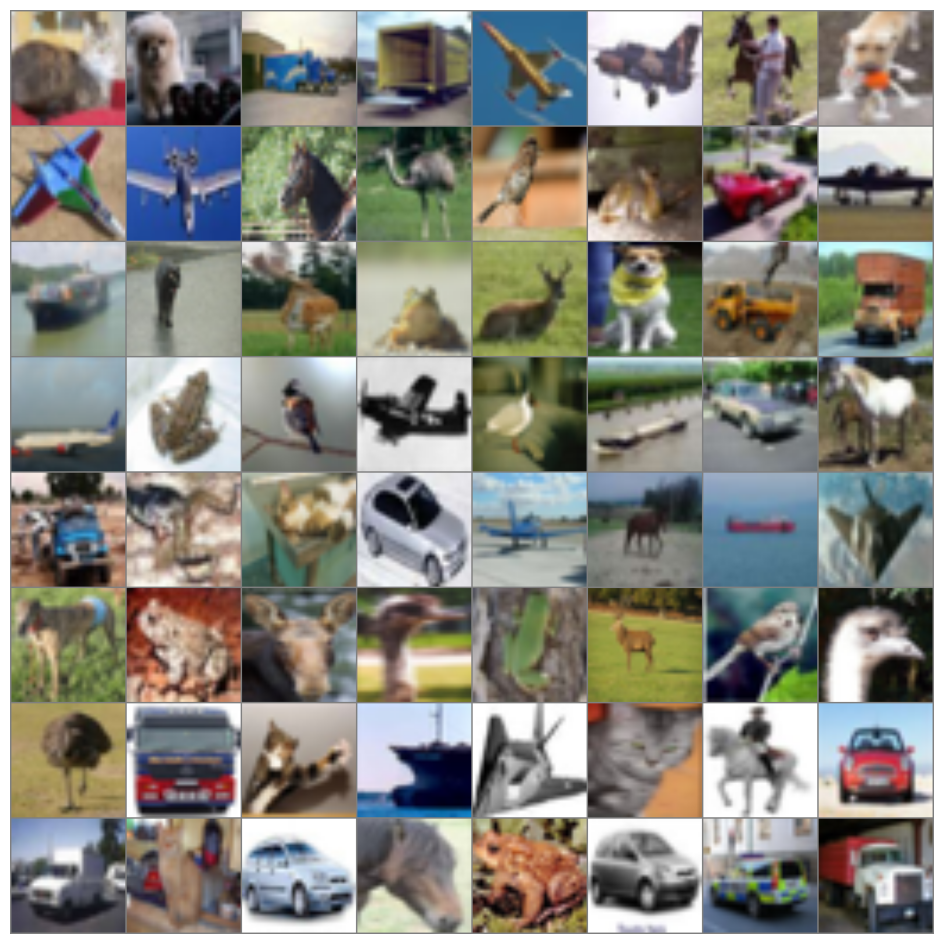

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = unnormalized_image_grid.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)


## Get class labels

In [7]:
# TODO: Get the label directly cifar10_classes = cifar10.classes

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(classes[labels[0]])  


cat


# Convolutional Variational Autoencoder (Conv-VAE)
https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb 

In [8]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model

In [9]:
# TODO: rename VAE model to CVAE
VAEOutput = namedtuple("VAEOutput", ["output", "codings_mean", "codings_logvar"])

class VAE(nn.Module):
    def __init__(self, codings_dim=32):
        super(VAE, self).__init__()
        self.codings_dim = codings_dim

        # Encoder: 3x32x32 -> 256x4x4
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # 32x32 -> 16x16
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# 4x4 -> 4x4
            nn.ReLU(inplace=True),
        )
        # self.flat_dim = 256 * 4 * 4  # 4096 <-- for image 32x32
        self.flat_dim = 256 * 20 * 20 # <-- for image 160x160

        # Variational heads
        self.fc_mu     = nn.Linear(self.flat_dim, codings_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, codings_dim)

        # Decoder: z -> 256x4x4 -> 3x32x32
        self.fc_dec = nn.Linear(codings_dim, self.flat_dim)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4->8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8->16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 16->32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),              # logits or probs (see note)
            nn.Sigmoid()  # <- keep this since your loss uses MSE on [0,1]
        )

    def encode(self, X):
        h = self.encoder_cnn(X).flatten(1)              # (B, 4096)
        mu = self.fc_mu(h)                               # (B, codings_dim)
        logvar = self.fc_logvar(h)                       # (B, codings_dim)
        return mu, logvar

    @staticmethod
    def sample_codings(mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, Z):
        # h = self.fc_dec(Z).view(-1, 256, 4, 4)          # (B,256,4,4) # <-- for image 32x32
        h = self.fc_dec(Z).view(-1, 256, 20, 20) # <-- for image 160x160
        x_recon = self.decoder_cnn(h)                   # (B,3,32,32) in [0,1]
        return x_recon

    def forward(self, X):
        mean, logvar = self.encode(X)
        Z = self.sample_codings(mean, logvar)
        output = self.decode(Z)
        return VAEOutput(output, mean, logvar)

## Model training

In [10]:
def vae_loss(y_pred, x_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    # MSE reconstruction
    recon = F.mse_loss(output, x_target)
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.pow(2), dim=-1).mean()
    # Scale KL to per-pixel magnitude
    n_pixels = x_target[0].numel()
    return recon + kl_weight * (kl_div / n_pixels)

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)  # compare recon to input
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs=20):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for index, (X_batch, _) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, X_batch)   # use input as target
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)

        train_metric = metric.compute().item()
        val_metric = evaluate_tm(model, valid_loader, metric).item()

        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        history["valid_metrics"].append(val_metric)

        print(f"Epoch {epoch+1:02d}/{n_epochs} "
              f"loss={history['train_losses'][-1]:.4f}, "
              f"train RMSE={train_metric:.4f}, val RMSE={val_metric:.4f}")
    return history


torch.manual_seed(42)
vae = VAE(codings_dim=32).to(device)
# TODO: hyperparameter to tune -> learning rate
optimizer = torch.optim.NAdam(vae.parameters(), lr=1e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)

history = train(vae, optimizer, vae_loss, rmse, train_loader, valid_loader, n_epochs=20)

Epoch 01/20 loss=187274.1311, train RMSE=0.4146, val RMSE=0.4014
Epoch 02/20 loss=0.1567, train RMSE=0.3944, val RMSE=0.3936
Epoch 03/20 loss=0.1532, train RMSE=0.3900, val RMSE=0.3924
Epoch 04/20 loss=0.1522, train RMSE=0.3887, val RMSE=0.3921
Epoch 05/20 loss=0.1515, train RMSE=0.3878, val RMSE=0.3910
Epoch 06/20 loss=0.1510, train RMSE=0.3871, val RMSE=0.3916
Epoch 07/20 loss=0.1506, train RMSE=0.3866, val RMSE=0.3913
Epoch 08/20 loss=0.1502, train RMSE=0.3860, val RMSE=0.3905
Epoch 09/20 loss=0.1498, train RMSE=0.3855, val RMSE=0.3918
Epoch 10/20 loss=0.1495, train RMSE=0.3851, val RMSE=0.3904
Epoch 11/20 loss=0.1492, train RMSE=0.3847, val RMSE=0.3903
Epoch 12/20 loss=0.1489, train RMSE=0.3843, val RMSE=0.3904
Epoch 13/20 loss=0.1486, train RMSE=0.3840, val RMSE=0.3904
Epoch 14/20 loss=0.1483, train RMSE=0.3836, val RMSE=0.3906
Epoch 15/20 loss=0.1480, train RMSE=0.3832, val RMSE=0.3906
Epoch 16/20 loss=0.1478, train RMSE=0.3829, val RMSE=0.3907
Epoch 17/20 loss=0.1475, train RMSE

## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.6].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid rang

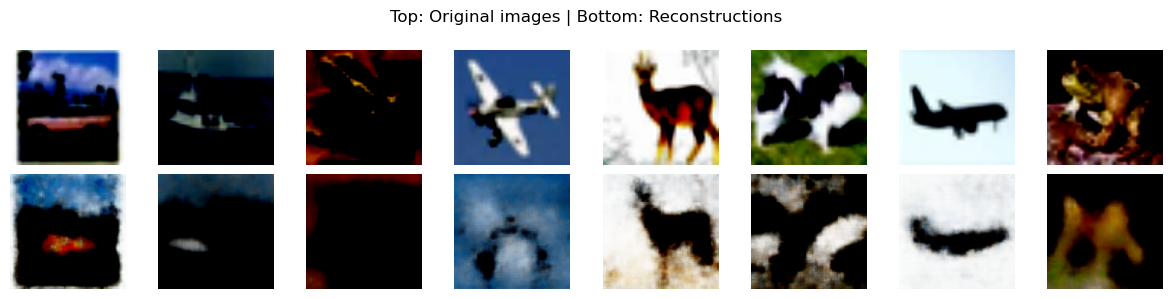

In [16]:
import matplotlib.pyplot as plt
import torch

def plot_image(img):
    """Convert a tensor to a displayable image and plot it."""
    img = img.detach().cpu()
    if img.ndim == 3:
        img = img.permute(1, 2, 0)  # (C,H,W) -> (H,W,C)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

def plot_reconstructions(model, data_loader, n_images=8):
    """
    Show original (top row) and reconstructed (bottom row) images from the VAE.
    """
    model.eval()

    # --- Get a batch of images ---
    X_batch, _ = next(iter(data_loader))
    X_batch = X_batch.to(device)
    X_batch = X_batch[:n_images]  # take first n_images only

    # --- Forward pass ---
    with torch.no_grad():
        out = model(X_batch)
        recon = out.output if hasattr(out, "output") else out

    # --- Plot originals and reconstructions ---
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 1.5, 3))

    for i in range(n_images):
        # Top row: original
        axes[0, i].imshow(X_batch[i].detach().cpu().permute(1, 2, 0))
        axes[0, i].axis("off")

        # Bottom row: reconstruction
        axes[1, i].imshow(recon[i].detach().cpu().permute(1, 2, 0))
        axes[1, i].axis("off")
    

    fig.suptitle("Top: Original images | Bottom: Reconstructions", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Use it ---
plot_reconstructions(vae, valid_loader, n_images=8)


# Exploration of the latent represenation (umap)

Overall structure

* The map shows a continuous, dense cloud rather than distinct clusters.

* That’s expected — your autoencoder is trained unsupervised only to reconstruct images, not to separate classes.

* Therefore, latent codes mainly capture visual similarity (colors, textures, shapes) rather than semantic categories.

# Find outliers
test 

# Sample from the latent distribution

# overlay with data points
What does it mean?

# Feature extraction 
From latent space

# Train classifier/regressor 
Using the latent space representation of the samples